In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pickle
from tqdm import trange
from typing import List

import datasets
from datasets import concatenate_datasets
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, RandomSampler
from torchmetrics.classification import MultilabelF1Score
from transformers import AutoTokenizer, AutoModel

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import Pipeline

from mcpt.contrastlearning import ContrastSampler, TrainerA
from utils import *
sns.set_theme(rc={'figure.figsize': [14, 8]})

In [2]:
dataset = get_dataset('data/en')
dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 433
})

In [4]:
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(dataset['text'])
with open('embeddings/mpnet_embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(dataset['text'])
with open('embeddings/minilm_embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [7]:
with open('embeddings/mpnet_embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)
embeddings.shape

(433, 768)

In [8]:
dataset_sentence_transformer = TensorDataset(
    torch.tensor(embeddings),
    torch.tensor(dataset['labels'], dtype=torch.float32),
)
# Average Max MicroF1: 0.6954783201217651
# Average Max MacroF1: 0.4917227327823639

# Add Standard Deviations as Feature

# Splits

# Transformers

In [9]:
criterion = nn.BCEWithLogitsLoss()
N_CLASSES = len(dataset['labels'][0])
N_EPOCHS=60
N_SPLITS=5
BATCH_SIZE=50
GAMMA=1.
LR=1e-3

In [13]:
def predict_KNN(train_embeddings, eval_embeddings, train_labels, temperature=.1, decision_boundary=None):
    dists = torch.cdist(eval_embeddings, train_embeddings)
    weights = torch.exp(-dists / temperature)
    weights = weights / weights.sum(1).unsqueeze(-1).expand(weights.shape)
    #print(dists.shape)
    nearest_neighbors = torch.argsort(dists)
    nearest_weights = torch.gather(weights, 1, nearest_neighbors)
    #print(nearest_weights.shape)
    nearest_labels = train_labels[nearest_neighbors]
    #print(nearest_labels.shape)
    knearest_logits = (nearest_weights.unsqueeze(-1).expand(nearest_labels.shape) * nearest_labels).sum(1)
    #print(knearest_logits.shape)

    if decision_boundary:
        return (knearest_logits > decision_boundary).int()
    return knearest_logits

In [14]:
class Trainer:
    def __init__(self, model, train_dataset, eval_dataset, criterion, optimizer, scheduler, n_classes, n_train_classes=None, convert_predictions=None, alpha=.4):
        self.model = model
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        if not n_train_classes:
            n_train_classes = n_classes
        self.metrics = {
            'macro': MultilabelF1Score(num_labels=n_classes, average='macro'),
            'micro': MultilabelF1Score(num_labels=n_classes, average='micro'),
            'train_macro': MultilabelF1Score(num_labels=n_train_classes, average='macro'),
            'train_micro': MultilabelF1Score(num_labels=n_train_classes, average='micro'),
        }
        self.convert_predictions = convert_predictions
        train_sampler = RandomSampler(train_dataset)
        self.loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
        self.eval_loader = DataLoader(eval_dataset, batch_size=1000)
        self.alpha = alpha
        
    def train(self, n_epochs):
        epoch_losses = list()
        microf1 = list()
        macrof1 = list()
        train_microf1 = list()
        train_macrof1 = list()
        for i in range(n_epochs):
            losses = list()
            torch.set_grad_enabled(True)
            self.model.train()
            for batch in self.loader:
                embeddings, labels = batch
                prediction_probs = self.model(embeddings)
                loss = self.criterion(prediction_probs, labels)
                losses.append(loss.detach())
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            self.scheduler.step()

            self.model.eval()
            torch.set_grad_enabled(False)
            preds = list()
            labels = list()
            for batch in self.eval_loader:
                embeddings, ls = batch
                preds.append(torch.sigmoid(self.model(embeddings)))
                labels.append(ls)
            preds = torch.cat(preds)
            labels = torch.cat(labels)
            if self.convert_predictions:
                preds = torch.tensor(self.convert_predictions(preds.numpy(), labels.numpy()))
            knn_preds = predict_KNN(
                self.train_dataset.tensors[0],
                self.eval_dataset.tensors[0],
                self.train_dataset.tensors[1]
            )
            if self.convert_predictions:
                knn_preds = torch.tensor(self.convert_predictions(knn_preds.numpy(), labels.numpy()))
            preds = self.alpha*knn_preds + (1-self.alpha)*preds
            preds = preds > .5
            microf1.append(self.metrics['micro'](preds, labels).numpy())
            macrof1.append(self.metrics['macro'](preds, labels).numpy())
            preds = list()
            labels = list()
            for batch in self.loader:
                embeddings, ls = batch
                preds.append(torch.sigmoid(self.model(embeddings)))
                labels.append(ls)
            preds = torch.cat(preds)
            preds = torch.round(preds)
            labels = torch.cat(labels)
            train_microf1.append(self.metrics['train_micro'](preds, labels).numpy())
            train_macrof1.append(self.metrics['train_macro'](preds, labels).numpy())

            epoch_losses.append(np.mean(losses))
        return epoch_losses, microf1, macrof1, train_microf1, train_macrof1

In [15]:
def plot_torch_metrics(losses, microf1, macrof1, train_microf1, train_macrof1):
    fig, ax = plt.subplots()
    loss = ax.plot(losses, label='Loss')
    ax2 = ax.twinx()
    m1 = ax2.plot(microf1, c='red', label='MicroF1')
    m2 = ax2.plot(macrof1, c='orange', label='MacroF1')
    m3 = ax2.plot(train_microf1, c='red', label='Train MicroF1', linestyle='dotted')
    m4 = ax2.plot(train_macrof1, c='orange', label='Train MacroF1', linestyle='dotted')
    ax2.axhline(np.max(microf1), c='red', linestyle='dashed')
    ax2.axhline(np.max(macrof1), c='orange', linestyle='dashed')
    lns = loss+m1+m2+m3+m4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)
    plt.show()
    argmax_microf1 = np.argmax(microf1)
    print("MicroF1: ", microf1[argmax_microf1], " @ ", argmax_microf1)
    print("MacroF1: ", np.max(macrof1), " @ ", np.argmax(macrof1))
    print("MacroF1: ", macrof1[argmax_microf1], " @ ", argmax_microf1)

In [16]:
use_dataset = dataset_sentence_transformer
kf = KFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
metrics = list()
for train_idx, test_idx in kf.split(use_dataset):
    train_dataset, eval_dataset = TensorDataset(*use_dataset[train_idx]), TensorDataset(*use_dataset[test_idx])
        
    embedding_len = train_dataset[0][0].shape[0]
    head = nn.Sequential(
        nn.Linear(embedding_len, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, N_CLASSES),
        nn.Dropout(),
    )
    optimizer = torch.optim.AdamW(head.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
    trainer = Trainer(head, train_dataset, eval_dataset, criterion, optimizer, scheduler, N_CLASSES, alpha=.3)
    metrics.append(trainer.train(N_EPOCHS))

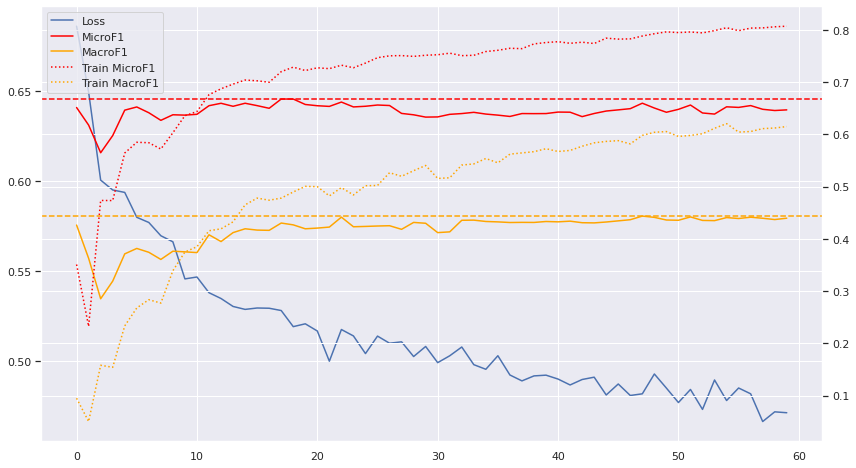

MicroF1:  0.66780823  @  17
MacroF1:  0.44374955  @  47
MacroF1:  0.43042117  @  17


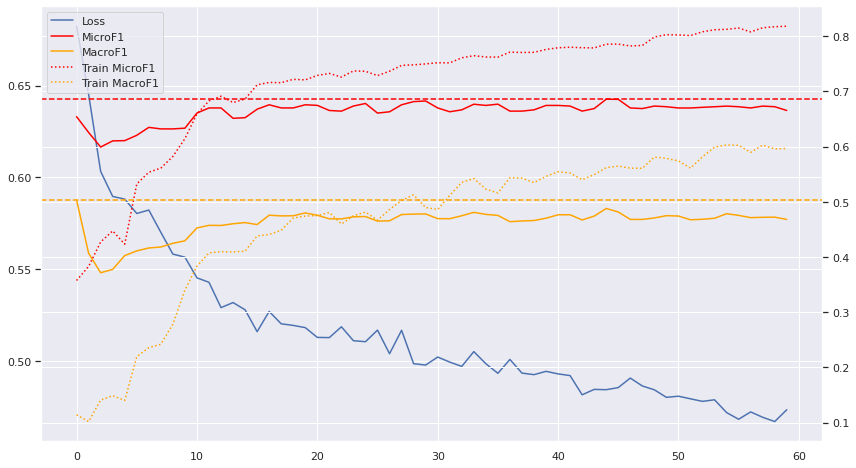

MicroF1:  0.6859083  @  44
MacroF1:  0.50318414  @  0
MacroF1:  0.48797923  @  44


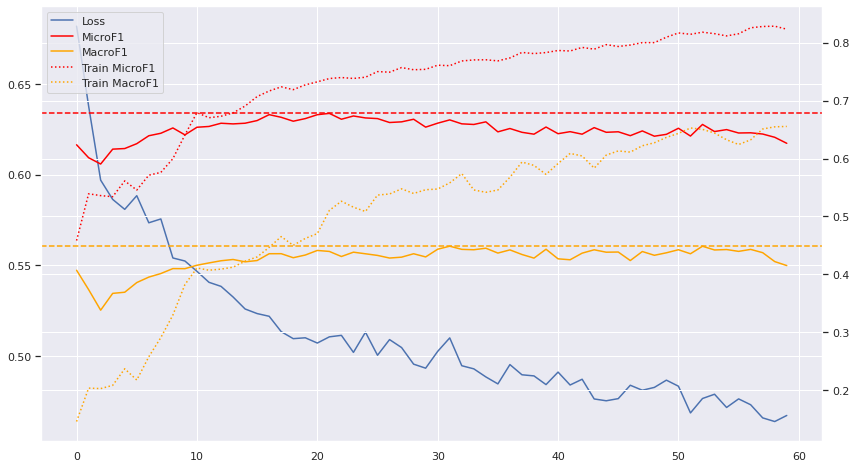

MicroF1:  0.67790896  @  21
MacroF1:  0.44873244  @  31
MacroF1:  0.4396833  @  21


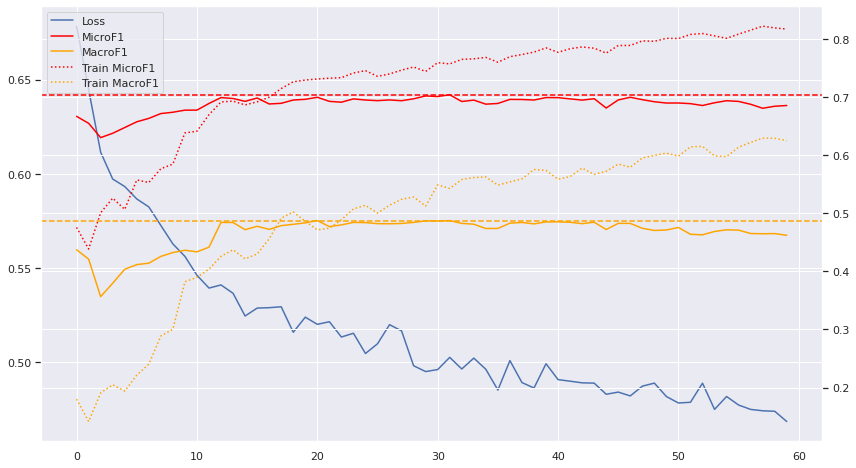

MicroF1:  0.70383275  @  31
MacroF1:  0.48740616  @  20
MacroF1:  0.48727268  @  31


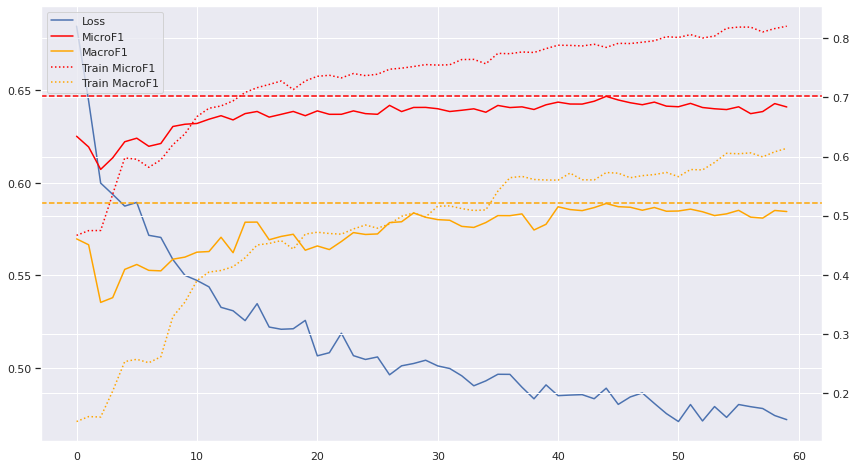

MicroF1:  0.7017544  @  44
MacroF1:  0.5205767  @  44
MacroF1:  0.5205767  @  44


In [17]:
for m in metrics:
    plot_torch_metrics(*m)

In [18]:
print(f'Average Max MicroF1: {np.mean(np.array([np.max(m[1]) for m in metrics]))}')
print(f'Average Max MacroF1: {np.mean(np.array([np.max(m[2]) for m in metrics]))}')

Average Max MicroF1: 0.6874425411224365
Average Max MacroF1: 0.48072975873947144


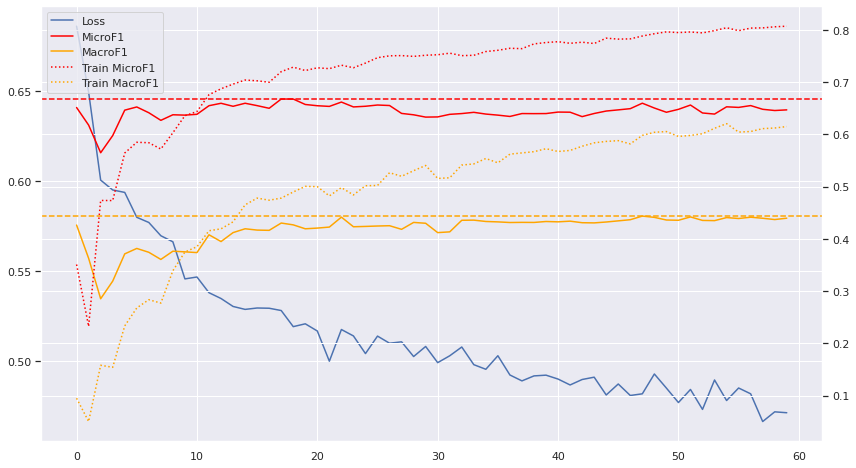

MicroF1:  0.66780823  @  17
MacroF1:  0.44374955  @  47
MacroF1:  0.43042117  @  17


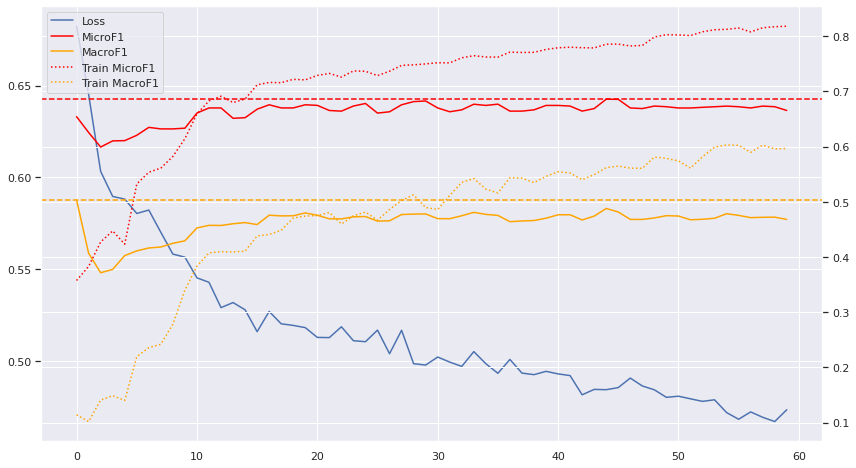

MicroF1:  0.6859083  @  44
MacroF1:  0.50318414  @  0
MacroF1:  0.48797923  @  44


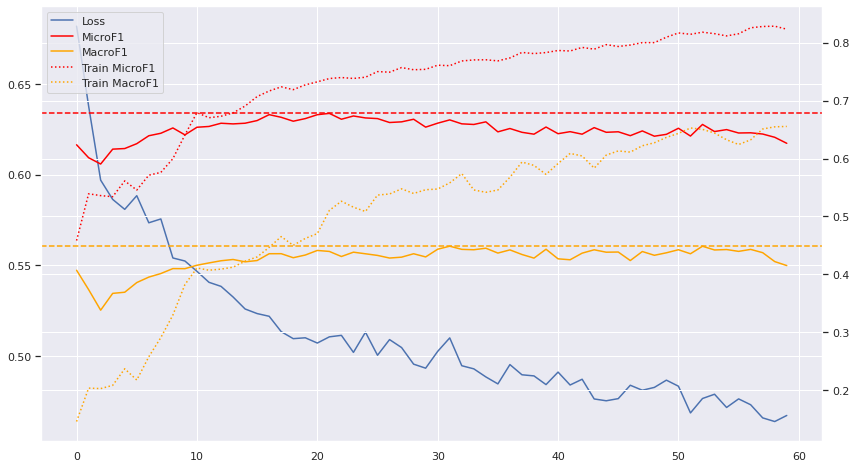

MicroF1:  0.67790896  @  21
MacroF1:  0.44873244  @  31
MacroF1:  0.4396833  @  21


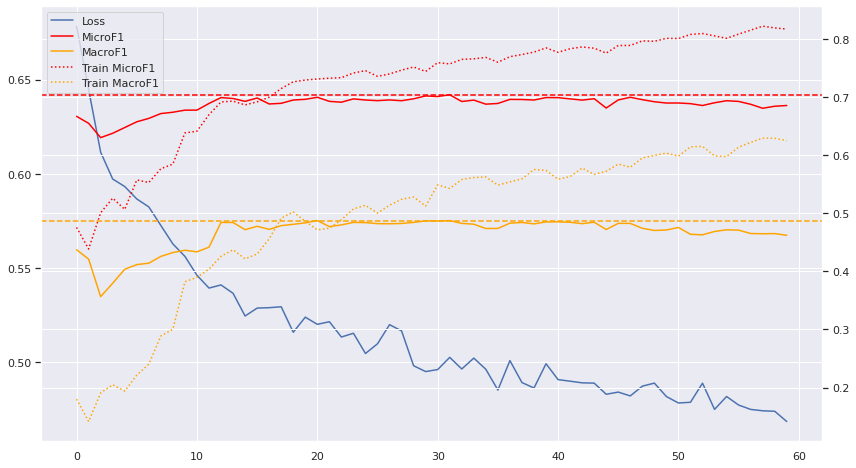

MicroF1:  0.70383275  @  31
MacroF1:  0.48740616  @  20
MacroF1:  0.48727268  @  31


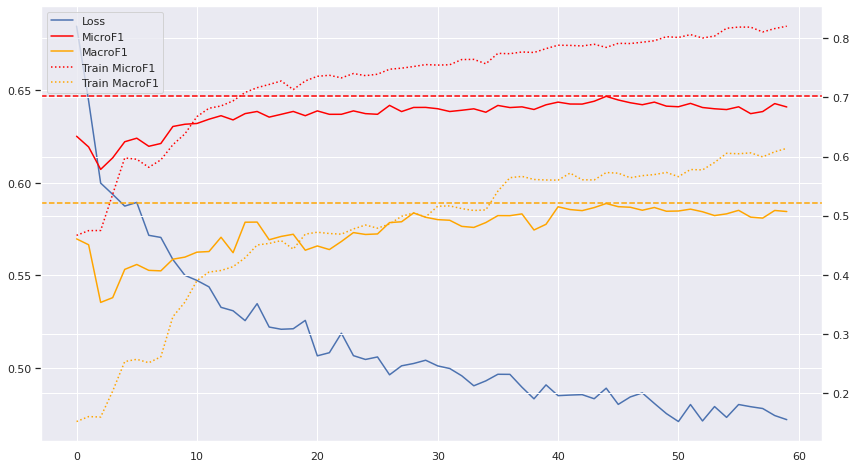

MicroF1:  0.7017544  @  44
MacroF1:  0.5205767  @  44
MacroF1:  0.5205767  @  44


In [17]:
for m in metrics:
    plot_torch_metrics(*m)

In [18]:
print(f'Average Max MicroF1: {np.mean(np.array([np.max(m[1]) for m in metrics]))}')
print(f'Average Max MacroF1: {np.mean(np.array([np.max(m[2]) for m in metrics]))}')

Average Max MicroF1: 0.6874425411224365
Average Max MacroF1: 0.48072975873947144


# K-Nearest

In [19]:
train_embeddings, train_labels = train_dataset.tensors
eval_embeddings, eval_labels = eval_dataset.tensors

In [20]:
knearest_logits = predict_KNN(
    train_dataset.tensors[0],
    eval_dataset.tensors[0],
    train_dataset.tensors[1]
)

In [21]:
decision_boundary = 100 / len(train_dataset)
decision_boundary

0.2881844380403458

In [22]:
f1_score((knearest_logits > .5).int().numpy(), eval_labels.numpy(), average='micro')

0.6460481099656357

# Analysis of Embeddings

In [23]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [24]:
encodings = tokenizer(dataset['text'], padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encodings)
token_embeddings = model_output[0]
input_mask_expanded = encodings['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
sentence_embeddings = sum_embeddings / sum_mask

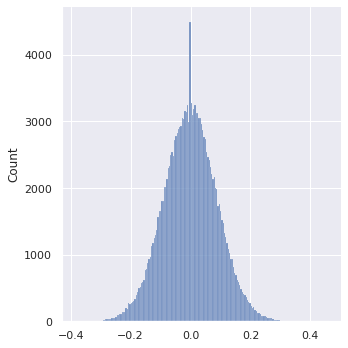

In [25]:
sns.displot(sentence_embeddings.flatten())

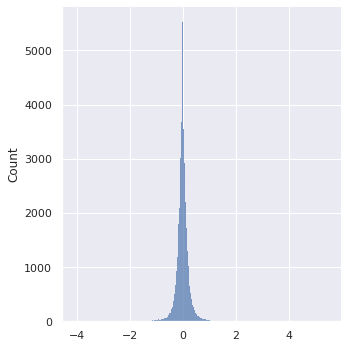

In [26]:
sns.displot(token_embeddings.numpy()[0].flatten())

<AxesSubplot: >

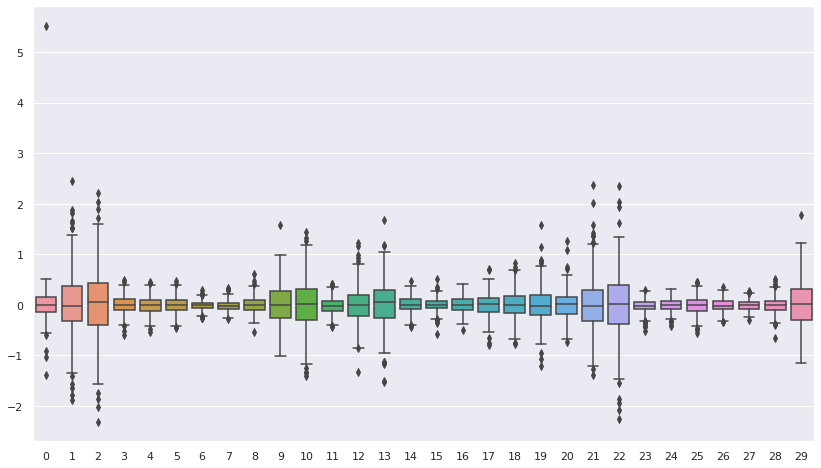

In [27]:
sns.boxplot(token_embeddings.numpy()[0][:30].T)

# Experiments

In [19]:
#sentence_embeddings_expanded = sentence_embeddings.unsqueeze(1).expand((433, 512, 384))
sentence_embeddings_expanded = sentence_embeddings.unsqueeze(1).expand(token_embeddings.size())
print(sentence_embeddings.shape)
print(sentence_embeddings_expanded.shape)
print(token_embeddings.shape)

torch.Size([433, 384])
torch.Size([433, 512, 384])
torch.Size([433, 512, 384])


In [20]:
first_sample_first_row = token_embeddings[0,:,0]
first_sample_first_row_mask = input_mask_expanded[0,:,0]
first_sample_first_row_mask_sum = torch.sum(first_sample_first_row_mask)
print(torch.sum(first_sample_first_row * first_sample_first_row_mask) / torch.sum(first_sample_first_row_mask))
print(sentence_embeddings[0, 0])

# wrong
#first_sample_first_row_diff = (first_sample_first_row - torch.mean(first_sample_first_row))
#first_sample_first_row_diff *= first_sample_first_row_diff
#torch.sqrt(torch.sum(first_sample_first_row_diff) / (512 - 1))

# correct
first_sample_first_row_diff = (first_sample_first_row - sentence_embeddings[0, 0]) * first_sample_first_row_mask
first_sample_first_row_diff *= first_sample_first_row_diff
torch.sqrt(torch.sum(first_sample_first_row_diff) / (first_sample_first_row_mask_sum - 1))

tensor(-0.0696)
tensor(-0.0696)


tensor(0.1983)

In [21]:
diffs = (token_embeddings - sentence_embeddings_expanded) * input_mask_expanded
diffs2 = diffs * diffs
diffs2_sum = torch.sum(diffs2, 1)
print(diffs2_sum.shape)
var = diffs2_sum / (sum_mask - 1) # Bessel correction
deviations = torch.sqrt(var)
print(deviations.shape)
deviations

torch.Size([433, 384])
torch.Size([433, 384])


tensor([[0.1983, 0.2261, 0.1904,  ..., 0.2458, 0.3153, 0.3233],
        [0.1925, 0.2031, 0.1687,  ..., 0.2518, 0.3703, 0.3065],
        [0.2141, 0.2089, 0.2270,  ..., 0.2479, 0.3396, 0.3541],
        ...,
        [0.2068, 0.2169, 0.2047,  ..., 0.2548, 0.2811, 0.3165],
        [0.1764, 0.2131, 0.1859,  ..., 0.2539, 0.2640, 0.3031],
        [0.1985, 0.1890, 0.1650,  ..., 0.2802, 0.3084, 0.4159]])

In [22]:
deviations2 = np.std(token_embeddings.numpy(), axis=1)
deviations2[deviations2 < 1e-9] = 1e-9
deviations2

array([[0.2020524 , 0.23724553, 0.1850178 , ..., 0.23385718, 0.31276432,
        0.30875406],
       [0.19231948, 0.20293163, 0.16853239, ..., 0.2515884 , 0.36997342,
        0.306222  ],
       [0.21392871, 0.2086979 , 0.22678374, ..., 0.24769099, 0.33925983,
        0.35371104],
       ...,
       [0.20659134, 0.2166799 , 0.20450021, ..., 0.2545951 , 0.28086874,
        0.3161912 ],
       [0.17623362, 0.21293984, 0.18576682, ..., 0.2536241 , 0.2637554 ,
        0.3028416 ],
       [0.2692299 , 0.20189661, 0.20666316, ..., 0.2032887 , 0.28444406,
        0.25786474]], dtype=float32)

In [23]:
#standardised_sentence_embeddings = np.clip(sentence_embeddings.numpy() / deviations2, a_min=-2, a_max=2)
standardised_sentence_embeddings = torch.clip(sentence_embeddings / deviations, -2, 2)

In [24]:
help(torch.clip)

Help on built-in function clip in module torch:

clip(...)
    clip(input, min=None, max=None, *, out=None) -> Tensor
    
    Alias for :func:`torch.clamp`.



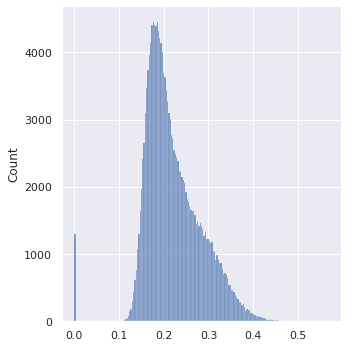

In [25]:
sns.displot(deviations.flatten())

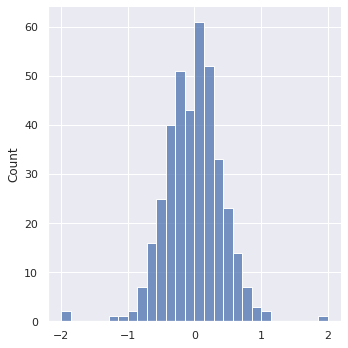

In [26]:
sns.displot(standardised_sentence_embeddings[0])